<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/master/romane_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn

     |████████████████████████████████| 778kB 2.8MB/s 


In [2]:
!pip install -U yellowbrick

     |████████████████████████████████| 276kB 2.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from scipy.fftpack import fft,ifft

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[np.random.randint(len(self.symbols))]
      TS = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = np.random.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

In [5]:
nb_timeseries = 2000

gen = TS_generator(nb_timeseries=nb_timeseries, chunk_size=100) #default values but just for the syntax
X = gen.get_array()

In [6]:
#Apply MinMax Scaling
X_scaled = MinMaxScaler().fit_transform(X.T).T

#Apply Fourier Transform for test
X_ft = fft(X_scaled)
print(X_ft[0][:10]) #first 10 coefficients

[42.22353593 -0.j         -1.30060361+10.1134836j
  1.22279218 +3.02373192j  4.4743843  +7.33680344j
 -3.40083037 +2.18876033j -0.67084627 +1.22926078j
 -1.04452028 +1.87048924j  0.89692443 +1.4243574j
 -0.17539616 +3.99128404j -0.82037646 +1.72289335j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


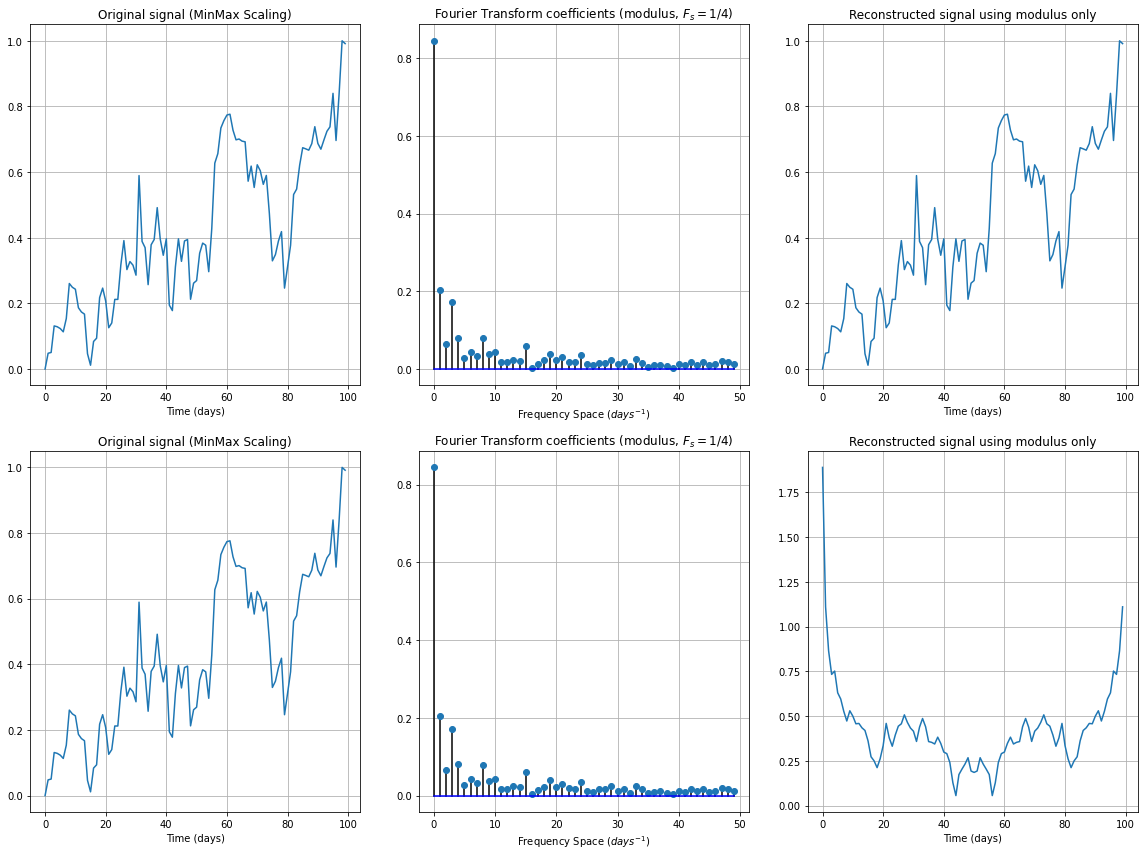

In [7]:
#First approach: Use modulus only
i=0
j=2

# sampling rate: f_max /2 - let's say the smallest pattern is 2 days
Fs = 1/4 
n = X_scaled.shape[1]
fr = Fs/2 * np.linspace(0,1,n//2)
X_ft_mod = 2/n * abs(X_ft)[:,0:np.size(fr)]

X_ft_reconstructed = ifft(abs(X_ft)).real
X_ft_complex_reconstructured = ifft(X_ft)

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (MinMax Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[0,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[0,1].grid()

axes[0,2].plot(X_ft_complex_reconstructured[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using modulus only')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[i])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (MinMax Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[1,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[1,1].grid()

axes[1,2].plot(X_ft_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using modulus only')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()

plt.tight_layout()
plt.show()

## 1. Concatenate Imaginary and Real Parts

In [8]:
#real/imaginary concat
X_ft_subs_ri = []

for i in X_ft:
  X_ft_subs_ri.append(i[1:12])

X_ft_subs_ri = np.array(X_ft_subs_ri)
X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

X_ft_subs_ri[:5]

array([[ -1.30060361,   1.22279218,   4.4743843 ,  -3.40083037,
         -0.67084627,  -1.04452028,   0.89692443,  -0.17539616,
         -0.82037646,  -0.0387415 ,   0.52691593,  10.1134836 ,
          3.02373192,   7.33680344,   2.18876033,   1.22926078,
          1.87048924,   1.4243574 ,   3.99128404,   1.72289335,
          2.16991954,   0.69912622],
       [ -4.30960937,  -0.38855433,   1.10921044,  -0.6641597 ,
          1.79199586,  -0.8736413 ,   0.14407509,  -0.02415622,
         -0.44260371,  -0.07207099,  -0.88346131,  20.81997966,
          1.2946384 ,   2.48369231,  -0.23991243,   1.89547082,
          1.88303981,   1.24731533,   0.94125622,   0.26458427,
          0.71519632,   0.48391093],
       [ -9.15059834,   0.9400985 ,  -3.03653887,   0.54910686,
         -1.17437693,  -0.17619468,   0.25972735,  -1.59213046,
         -1.21640993,  -1.39175647,   0.74372436,   4.37043926,
         -0.95160348,   4.88552698,   1.63101129,   1.575614  ,
          0.62096689,   0.1584

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


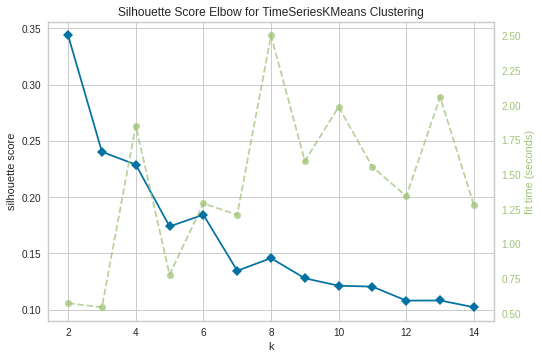

In [9]:
#Find best k
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model1 = TimeSeriesKMeans()
visualizer = KElbowVisualizer(model1, k=(2,15), metric='silhouette')

visualizer.fit(X_ft_subs_ri)        # Fit the data to the visualizer
visualizer.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


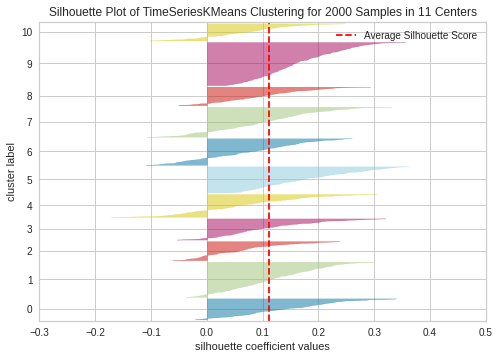

In [10]:
#silhouette scores for each cluster for best k
model1 = TimeSeriesKMeans(n_clusters=11)
visualizer = SilhouetteVisualizer(model1, colors='yellowbrick')
visualizer.fit(X_ft_subs_ri) 
visualizer.show()

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


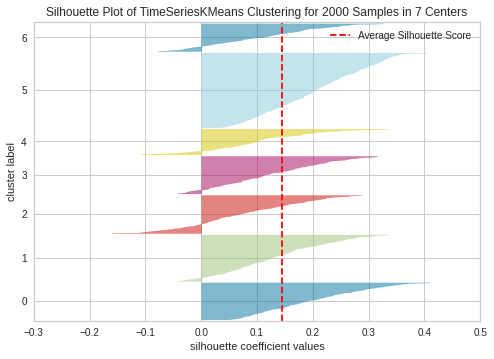

In [11]:
model_ri = TimeSeriesKMeans(n_clusters=7)
visualizer_ri = SilhouetteVisualizer(model_ri, colors='yellowbrick')
visualizer_ri.fit(X_ft_subs_ri) 
visualizer_ri.show()

## 2. Module

In [12]:
#taking only the modulus
X_ft_subs = []

for i in X_ft:
  X_ft_subs.append(i[1:13])

X_ft_subs = np.array(X_ft_subs)
X_ft_subs = X_ft_subs.real
X_ft_subs[:10]

array([[-1.30060361e+00,  1.22279218e+00,  4.47438430e+00,
        -3.40083037e+00, -6.70846266e-01, -1.04452028e+00,
         8.96924425e-01, -1.75396160e-01, -8.20376456e-01,
        -3.87415040e-02,  5.26915929e-01, -4.96350374e-01],
       [-4.30960937e+00, -3.88554328e-01,  1.10921044e+00,
        -6.64159696e-01,  1.79199586e+00, -8.73641305e-01,
         1.44075088e-01, -2.41562194e-02, -4.42603711e-01,
        -7.20709892e-02, -8.83461313e-01,  5.76497696e-02],
       [-9.15059834e+00,  9.40098504e-01, -3.03653887e+00,
         5.49106856e-01, -1.17437693e+00, -1.76194682e-01,
         2.59727353e-01, -1.59213046e+00, -1.21640993e+00,
        -1.39175647e+00,  7.43724359e-01, -5.43518098e-01],
       [-2.34099184e+00,  8.73376017e+00, -2.35453538e+00,
         3.56327097e+00,  4.29834152e+00, -1.30019486e+00,
        -2.22416194e+00,  2.56535196e-01, -4.55265507e-01,
         8.05767913e-01, -5.33400229e-01, -3.31397192e-01],
       [ 5.10507482e+00, -4.68314140e+00, -2.1925665

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


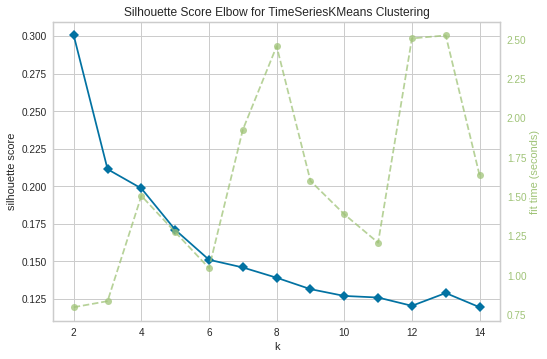

In [13]:
#Find best k
model2 = TimeSeriesKMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15), metric = 'silhouette')

visualizer2.fit(X_ft_subs)       # Fit the data to the visualizer
visualizer2.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


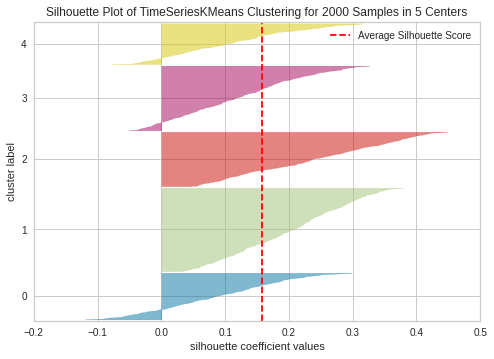

In [14]:
model2 = TimeSeriesKMeans(n_clusters=5)
visualizer2 = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer2.fit(X_ft_subs_ri) 
visualizer2.show()   

## 3. Optimization of the number of coefficient

### 3.1 Imaginery + real

2 to 3 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


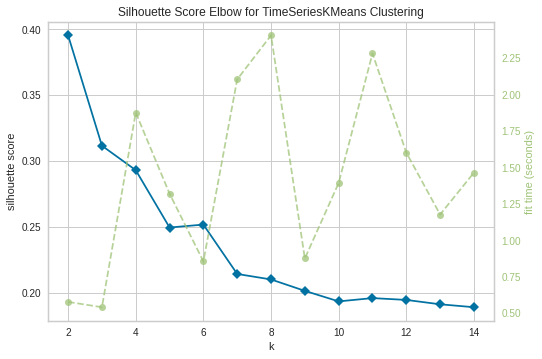

2 to 4 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


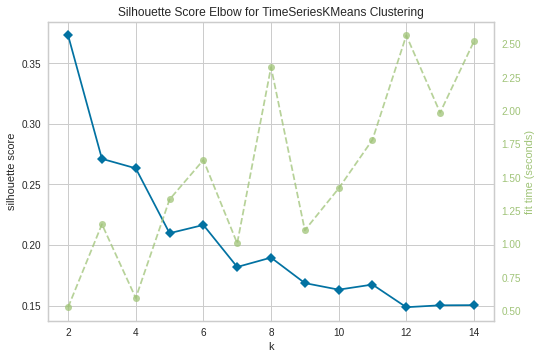

2 to 5 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


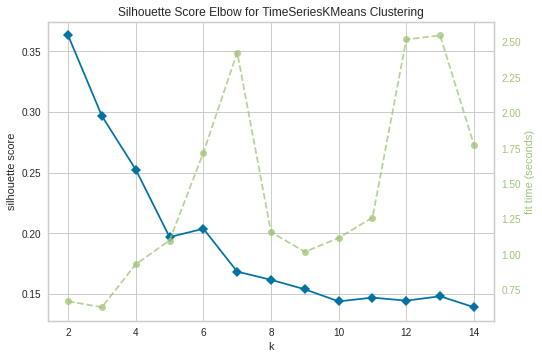

2 to 6 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


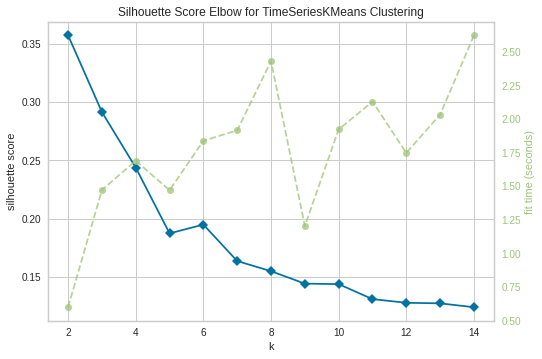

2 to 7 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


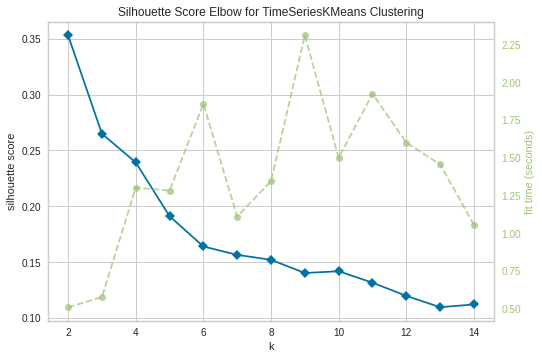

2 to 8 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


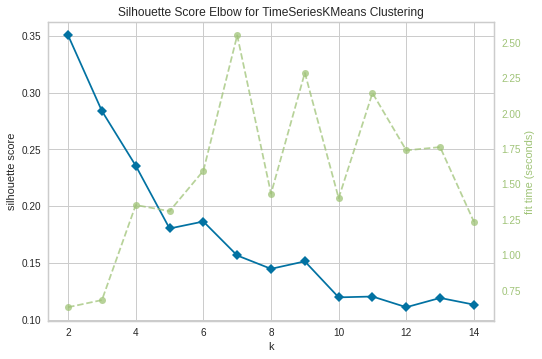

2 to 9 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


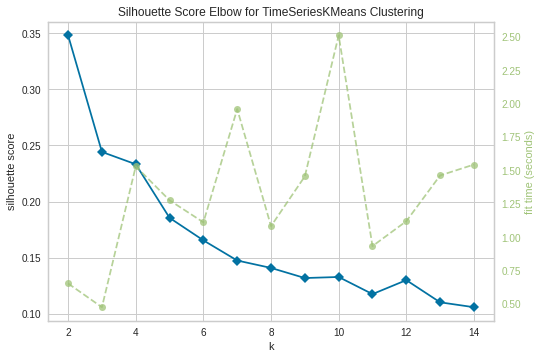

2 to 10 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


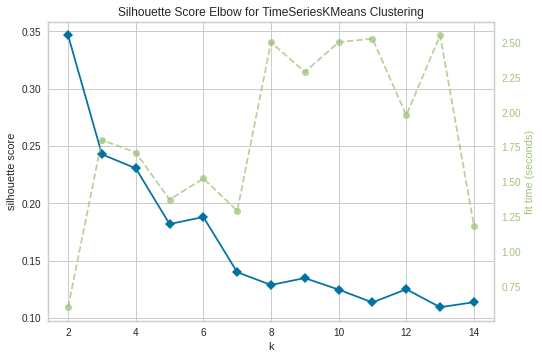

2 to 11 coefficients


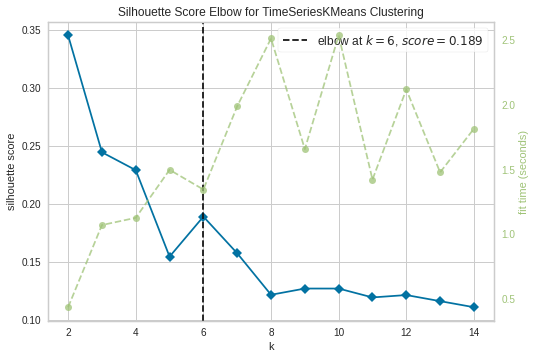

2 to 12 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


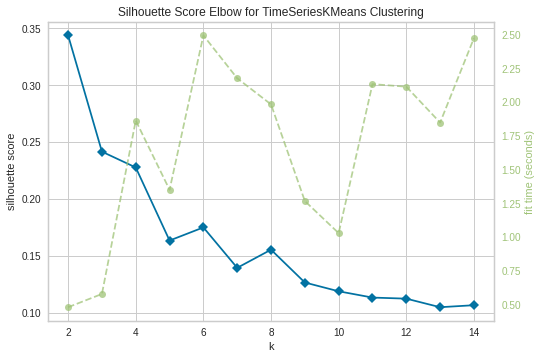

2 to 13 coefficients


KeyboardInterrupt: ignored

In [15]:
for j in range(3,14):

  X_ft_subs_ri = []

  for i in X_ft:
    X_ft_subs_ri.append(i[1:j])

  X_ft_subs_ri = np.array(X_ft_subs_ri)
  X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

  model_ri_best = TimeSeriesKMeans()
  visualizer_ri_best = KElbowVisualizer(model_ri_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_ri_best.fit(X_ft_subs_ri)       # Fit the data to the visualizer
  visualizer_ri_best.show();



In [ ]:
for j in range(3,14):

  X_ft_subs = []

  for i in X_ft:
    X_ft_subs.append(i[1:j])

  X_ft_subs = np.array(X_ft_subs)
  X_ft_subs = X_ft_subs.real
  X_ft_subs[:10]

  model_subs_best = TimeSeriesKMeans()
  visualizer_subs_best = KElbowVisualizer(model_subs_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_subs_best.fit(X_ft_subs)       # Fit the data to the visualizer
  visualizer_subs_best.show();

